In [1]:
from os import getcwd
import numpy as np
import pandas as pd

import re
import string
import nltk
from nltk.corpus import twitter_samples 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer


## Download dataset and english stopwords

In [2]:
# nltk.download('twitter_samples')
# nltk.download('stopwords')
# we need to download it just once!

In [3]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [4]:
len(all_positive_tweets),len(all_negative_tweets)

(5000, 5000)

### Some positive and negative examples

In [5]:
all_positive_tweets[0:5]

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days']

In [6]:
all_negative_tweets[0:5]

['hopeless for tmr :(',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
 '@Hegelbon That heart sliding into the waste basket. :(',
 '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too',
 'Dang starting next week I have "work" :(']

In [7]:
train_pos = all_positive_tweets[:4000]
test_pos = all_positive_tweets[4000:]
train_neg = all_negative_tweets[:4000]
test_neg = all_negative_tweets[4000:]

train = train_pos + train_neg
test = test_pos + test_neg

# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [8]:
train_y.shape, test_y.shape

((8000, 1), (2000, 1))

In [9]:
train[:2]

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!']

In [10]:
np.squeeze(train_y).shape

(8000,)

In [11]:
train_y = np.squeeze(train_y).tolist()
test_y = np.squeeze(test_y).tolist()
train_y[:2]

[1.0, 1.0]

## Clean text

In [12]:
nltk_stopwords = stopwords.words('english')
my_stopwords = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves",
                "you", "your", "yours", "yourself", "yourselves", "he", "him",
                "his", "himself", "she", "her", "hers", "herself", "it", "its",
                "itself", "they", "them", "their", "theirs", "themselves", "what",
                "which", "who", "whom", "this", "that", "these", "those", "am", "is",
                "are", "was", "were", "be", "been", "being", "have", "has", "had",
                "having", "do", "does", "did", "doing", "a", "an", "the", "and",
                "but", "if", "or", "because", "as", "until", "while", "of", "at",
                "by", "for", "with", "about", "against", "between", "into", "through",
                "during", "before", "after", "above", "below", "to", "from", "up",
                "down", "in", "out", "on", "off", "over", "under", "again", "further",
                "then", "once", "here", "there", "when", "where", "why", "how", "all",
                "any", "both", "each", "few", "more", "most", "other", "some", "such",
                "only", "own", "same", "so", "than", "too", "very",
                "can", "will", "just", "should", "now"}

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
print('not_'+'my')

not_my


In [15]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
tweet = "This is a didn't don't hadn't cooool #dummysmiley: :-) :-P <3 much for you!!!!!!"
print(tt.tokenize(tweet))
#type(tt.tokenize(tweet))


['This', 'is', 'a', "didn't", "don't", "hadn't", 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'much', 'for', 'you', '!', '!', '!']


## Manage emojis

In [16]:
def emoji(tweet):
    tweet = re.sub(r'(:\(?\()' , ':( ' , tweet)
    tweet = re.sub(r'(:\(:\()' , ':( ' , tweet)
    tweet = re.sub(r'(: \()' , ':( ' , tweet)
    tweet = re.sub(r'(:-\()' , ':( ' , tweet)
   
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\)|:-\)|\(:|\(-:|:\'\)|:o)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:d|:-d|x-?d|x-?d)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-) ,:p 
    tweet = re.sub(r'(;-?\)|;-?d|\(-?;|@-\)|:-?p)', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\(|:-\(|\):|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet

## Remove stop words

In [17]:
def stop_words(tweet):
    stopwords_english = my_stopwords
    
    # Lower tweets
    tweet = tweet.lower()
    
    # Replace contractoins
    for word in contractions:
        tweet = re.sub( word , contractions[word.lower()], tweet)
    
    # Remove Stopwords
    tweet = ' '.join([word for word in tweet.split() if word not in stopwords_english])
        
    return tweet

## Negation handling

In [18]:
import json
with open('contractions.json', 'r') as f:
   contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

def negation(tweet):
    
    #for word in contractions:
    #    tweet = re.sub( word , contractions[word.lower()], tweet.lower())
    
    tweet = emoji(tweet)                                              # Replaces Emojis

    tokenizer = TweetTokenizer(strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    tweets_clean = ""
    flag = 0
    for word in tweet_tokens:
        if(flag == 0):
            if(len(word)>1):
                tweets_clean += word + ' '
                #tweets_clean.append(word)
        if (word == 'not'):
            flag = 1
        if(word == '.' or word == ','):
            flag = 0
        if(flag == 1 and word != 'not'):
            if(len(word)>1):
                tweets_clean += 'not_'+ word + ' '
        
    return tweets_clean 

In [19]:
tweet = "This isn't cool! for not you, but it is nice!!!!!!"
print("Tweet is: ", tweet)
sw = stop_words(tweet)
print("After replacing contractions and stop-words: ", sw)
print("Do negation handling: ", negation(sw))

Tweet is:  This isn't cool! for not you, but it is nice!!!!!!
After replacing contractions and stop-words:  not cool! not you, nice!!!!!!
Do negation handling:  not not_cool not_you nice 


In [20]:
print(SnowballStemmer("english").stem("generously"))
#generous
print(SnowballStemmer("porter").stem("generously"))
#gener

generous
gener


In [21]:
def process_tweet(tweet):

    tweet = stop_words(tweet)                                          #replace contractions and stop-words
    
    #tweet = re.sub(r'\.','',tweet)                                     # Remove dots
    
    tweet = re.sub('@[^\s]+', '', tweet)                               # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)    # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                            # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                                # Remove (&quot;) 
    #tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                          # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                            # Replaces double spaces with single space   
    #tweet = re.sub(r'\$\w*', '', tweet)                               # Remove stock market tickers like $GE
    #tweet = re.sub(r'^RT[\s]+', '', tweet)                            # Remove old style retweet text "RT"
    tweet = re.sub(r'#', '', tweet)                                   # Only removing the hash # sign from the word
    
    tweet = negation(tweet)                                            
    tweet = re.sub(r'\.','',tweet)                                     # Remove dots
           
    #stemmer = PorterStemmer()
    stemmer = SnowballStemmer("english")
    
    nltk_stopwords = stopwords.words('english')
    nltk_stopwords2 = []
    for word in nltk_stopwords:
        nltk_stopwords2.append(word)
        nltk_stopwords2.append('not_' + word)
        
    stopwords_english = nltk_stopwords2
    #stopwords_english = my_stopwords
    
    # tokenize tweets
    tokenizer = TweetTokenizer(strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    lemmatizer = WordNetLemmatizer()
    
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and              # Remove stopwords
                word not in string.punctuation):           # Remove punctuation
            # tweets_clean.append(word)
            clean_word = lemmatizer.lemmatize(word)        # Lemmatize word
            #clean_word = stemmer.stem(word)               # Stemming word
            #clean_word = word
            if(len(clean_word)>1):
                tweets_clean.append(clean_word)   
    
    return tweets_clean

In [22]:
index = np.random.randint(0,7999, 1)[0]
train[index],process_tweet(train[index])

("@DawsePaul haha I guess I'm not a video game nerd. I do like Christophe Gans' other films though - check Brotherhood of the Wolf out :)",
 ['haha',
  'guess',
  'not_video',
  'not_game',
  'not_nerd',
  'like',
  'christophe',
  'gans',
  'film',
  'though',
  'check',
  'brotherhood',
  'wolf',
  'positiveemoji'])

## Make dictionary of count of each word in text

In [23]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    freqs={}
    for label,tweet in zip(ys,tweets):
        for word in process_tweet(tweet):
            pair = (word, label)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [24]:
def n_gram(tweets , n = 2):
    from sklearn.feature_extraction.text import CountVectorizer
    count_vectorizer = CountVectorizer(ngram_range=(n-1,n))    # (N-1)gram and Ngram
    vectorized_data = count_vectorizer.fit_transform(tweets)  
    
    return vectorized_data

In [25]:
freqs = build_freqs(train, train_y)

tweet = "Thank you for your support :), won't forget http://t.co/ihELksfJjT,@%%*"
tweet = process_tweet(tweet)
print(tweet)
#print(freqs)
for word in tweet:
    print(word , "-> ", "neg_freauency: " , freqs[(word , 0)])
    print(word , "-> ", "pos_freauency: " , freqs[(word , 1)])

['thank', 'support', 'positiveemoji', 'not_forget']
thank ->  neg_freauency:  20
thank ->  pos_freauency:  189
support ->  neg_freauency:  13
support ->  pos_freauency:  22
positiveemoji ->  neg_freauency:  24
positiveemoji ->  pos_freauency:  4013
not_forget ->  neg_freauency:  2
not_forget ->  pos_freauency:  8


In [26]:
dic2 = dict(sorted(freqs.items(), key=lambda item: item[1],reverse=True))
print(dic2)

{('positiveemoji', 1.0): 4013, ('negetiveemoji', 0.0): 3613, ('not_negetiveemoji', 0.0): 551, ('thanks', 1.0): 328, ('follow', 1.0): 270, ('love', 1.0): 269, ('please', 0.0): 232, ('miss', 0.0): 195, ('thank', 1.0): 189, ('not_positiveemoji', 1.0): 187, ('good', 1.0): 186, ('day', 1.0): 185, ('like', 1.0): 163, ('hi', 1.0): 154, ('like', 0.0): 145, ('happy', 1.0): 143, ('want', 0.0): 139, ('back', 1.0): 136, ('see', 1.0): 136, ('great', 1.0): 132, ('get', 1.0): 129, ('follow', 0.0): 121, ('love', 0.0): 115, ('get', 0.0): 113, ('new', 1.0): 111, ('sorry', 0.0): 111, ('time', 0.0): 111, ('know', 1.0): 110, ('much', 0.0): 110, ('followed', 0.0): 109, ('one', 0.0): 107, ('day', 0.0): 105, ('im', 0.0): 103, ('really', 0.0): 99, ('would', 1.0): 97, ('still', 0.0): 97, ('hope', 1.0): 96, ('shall', 1.0): 96, ('go', 0.0): 93, ('sad', 0.0): 90, ('one', 1.0): 89, ('time', 1.0): 89, ('friday', 1.0): 89, ('today', 1.0): 88, ('let', 1.0): 87, ('got', 0.0): 83, ('back', 0.0): 80, ('lot', 1.0): 79, ('

In [27]:
len(freqs.keys())

12852

## Implement logestic regression

### sigmoid function

In [28]:
def sigmoid(z): 
    
    h = 1 / (1 + np.exp(-z))
    
    return h

### gradient decent

In [29]:
def gradientDescent(x, y, theta, alpha, num_iters):

    m = x.shape[0]
    
    for i in range(0, num_iters):
        
        z = np.dot(x,theta)
        h = sigmoid(z)
        
        # calculate the cost function for logestic regressin
        J = -1./m * (np.dot(y.T, np.log(h)) + np.dot((1-y).T,np.log(1-h)))                                                    

        # update the weights theta
        theta = theta - (alpha/m) * np.dot(x.T,(h-y))
        
    J = float(J)
    return J, theta

In [30]:
#examin our function
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]


## Extract text features

In [31]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 

    for word in word_l:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word, 1.0),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word, 0.0),0)
    
    return x

In [32]:
index = np.random.randint(0,7999, 1)[0]
print(train[index])
print(extract_features(train[index],freqs))

tweet = "I am sad"
print(tweet)
print(extract_features(tweet,freqs))

An apartment makeover? http://t.co/ctLa1jppdb great ideas for factory living :)
[[1.000e+00 4.174e+03 4.800e+01]]
I am sad
[[ 1.  4. 90.]]


In [33]:
X = np.zeros((len(train), 3))
for i in range(len(train)):
    X[i, :]= extract_features(train[i], freqs)

In [34]:
X.shape

(8000, 3)

In [35]:
X

array([[1.000e+00, 4.186e+03, 7.900e+01],
       [1.000e+00, 4.547e+03, 4.030e+02],
       [1.000e+00, 4.156e+03, 1.140e+02],
       ...,
       [1.000e+00, 6.600e+01, 6.660e+02],
       [1.000e+00, 1.190e+02, 3.769e+03],
       [1.000e+00, 1.740e+02, 3.866e+03]])

In [36]:
Y = np.array(train_y).reshape(-1,1)
# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.1487164813885834.
The resulting vector of weights is [-4e-08, 0.00056527, -0.00057275]


## Test model


In [37]:
def prediction(tweet,freqs,theta):
    
    x = extract_features(tweet, freqs)
    y_pred = sigmoid(np.dot(x,theta))
    return y_pred

In [50]:
tweet = "I don't dismiss that movie ... (:  "
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great', tweet]:
    print( '%s -> %f' % (tweet, prediction(tweet, freqs, theta)))

I am happy -> 0.518196
I am bad -> 0.494117
this movie should have been great. -> 0.517044
great -> 0.517072
great great -> 0.534104
great great great -> 0.551058
great great great great -> 0.567893
I don't dismiss that movie ... (:   -> 0.525971


In [39]:
## Test model
def test_logistic_regression(test_x, test_y, freqs, theta):
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = prediction(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            y_hat.append(0)

    accuracy = (y_hat==np.squeeze(test_y)).sum()/len(test_x)

    for i in range(len(y_hat)):
        if (y_hat[i] != test_y[i] ):
            print(test[i], test_y[i])
            print(process_tweet(test[i]))
        
    return y_hat, accuracy

In [40]:
y_pred, tmp_accuracy  = test_logistic_regression(test, test_y, freqs, theta)

Kanin please :( xD 0.0
['kanin', 'please', 'negetiveemoji', 'positiveemoji']
@michaelsutthako morning , i miss you :( :* 0.0
['morning', 'miss', 'negetiveemoji', 'positiveemoji']


In [41]:
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9990


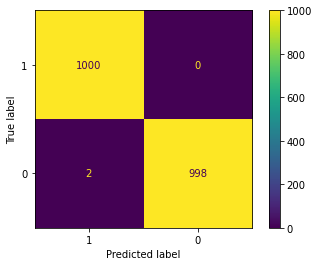

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_y, y_pred, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[1,0])
disp.plot()
plt.show()

In [43]:
from sklearn.metrics import f1_score
print("F1_Score: ", f1_score(test_y, y_pred, average=None))

from sklearn.metrics import precision_score
print("precision_score: ", precision_score(test_y, y_pred, average=None,zero_division=1))

from sklearn.metrics import recall_score
print("recall_score:", recall_score(test_y, y_pred, average=None, zero_division=1))

from sklearn.metrics import matthews_corrcoef
print("matthews_corrcoef:" , matthews_corrcoef(test_y, y_pred) )

from sklearn.metrics import log_loss
print("log_loss:" , log_loss(test_y, y_pred) )

F1_Score:  [0.998999 0.999001]
precision_score:  [1.         0.99800399]
recall_score: [0.998 1.   ]
matthews_corrcoef: 0.998001996005988
log_loss: 0.034539575992341864
